<a href="https://colab.research.google.com/github/shah-zeb-naveed/nlp/blob/main/nlp_pre_interview_refresher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Zero to Hero

In [ ]:
x, y = 0.3, 0.6

In [ ]:
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
# https://pberba.github.io/stats/2020/07/08/intro-hdbscan/

In [ ]:
%pip install --upgrade pyLDAvis scikit-learn hdbscan --quiet --progress-bar off

In [ ]:
%pip install scipy==1.10.1 svgling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
import scipy
assert scipy.__version__ == '1.10.1'
from __future__ import print_function
import pyLDAvis
#import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import re

#import torch
#from sentence_transformers import SentenceTransformer
#from bertopic import BERTopic
#from umap import UMAP

import hdbscan
import logging
logging.basicConfig()


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Define docs

In [ ]:
from sklearn.datasets import fetch_20newsgroups
# docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data'][0:1000]

docs = [
    "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.",
    "The tower is 324 meters tall, about the same height as an 81-story building.",
    "It held this title for 41 years until the Chrysler Building in New York City was finished in 1930.",
    "The tower has three levels for visitors, with restaurants on the first and second levels.",
    "Tickets can be purchased to ascend by stairs or lift to the first and second levels.",
]


# # Save the documents to disk
# with open('docs.pkl', 'wb') as file:
#     pickle.dump(docs, file)

docs[0:1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.']

In [ ]:
# with open('docs.pkl', 'rb') as file:
#     docs = pickle.load(file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vectorizer = CountVectorizer()
vectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CountVectorizer()

In [ ]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [ ]:
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['this', 'is', 'text', 'document', 'to', 'analyze']

In [ ]:
vectorizer.get_feature_names_out()

X.toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [ ]:
vectorizer.transform(['Something completely new.']).toarray() # ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# to preserve ordering to some extent can use bigrams
bigram_counts = CountVectorizer(ngram_range=(1,2))
bigram_counts.fit_transform(corpus).toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]])

In [ ]:
bigram_counts.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['and', 'and the', 'document', 'first', 'first document', 'is',
       'is the', 'is this', 'one', 'second', 'second document',
       'second second', 'the', 'the first', 'the second', 'the third',
       'third', 'third one', 'this', 'this is', 'this the'], dtype=object)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TfidfTransformer(smooth_idf=False)

In [ ]:
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]

tfidf = transformer.fit_transform(counts)
tfidf

tfidf.toarray() # each row a unit vector normalzied by eculidean norm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

In [ ]:
transformer = TfidfTransformer()
transformer.fit_transform(counts).toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.85151335, 0.        , 0.52433293],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.55422893, 0.83236428, 0.        ],
       [0.63035731, 0.        , 0.77630514]])

In [ ]:
transformer.idf_ # weifhts of each feature # maybe related to IDFs (some partial calculation)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1.        , 2.25276297, 1.84729786])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus).toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.27230147, 0.        , 0.27230147, 0.        ,
        0.85322574, 0.22262429, 0.        , 0.27230147],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

In [ ]:
# short texts noisty tfidf. binary occurrence as used in naive bayes can be set in CountVectorizer (binary=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# bow: cannot capture phrases/multi-words although can use ngrams, order, grammaer, potential misspellings, word derivations
# chars can help in misspellings

# analyzer is essetnial tokenizer

ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
counts = ngram_vectorizer.fit_transform(['words', 'wprds'])
ngram_vectorizer.get_feature_names_out()
counts.toarray().astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([' w', 'ds', 'or', 'pr', 'rd', 's ', 'wo', 'wp'], dtype=object)

array([[1, 1, 1, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 1]])

In [ ]:
ngram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
ngram_vectorizer.fit_transform(['jumpy fox'])
ngram_vectorizer.get_feature_names_out()


# across words. more noisy than white-space aware char_wb
ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
ngram_vectorizer.fit_transform(['jumpy fox'])
ngram_vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<1x8 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

array([' fo', ' ju', 'fox', 'jum', 'mpy', 'ox ', 'py ', 'ump'],
      dtype=object)

<1x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

array([' fo', 'fox', 'jum', 'mpy', 'py ', 'ump', 'y f'], dtype=object)

In [ ]:
ngram_vectorizer.vocabulary_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'jum': 2, 'ump': 5, 'mpy': 3, 'py ': 4, 'y f': 6, ' fo': 0, 'fox': 1}

In [ ]:
ngram_vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([' fo', 'fox', 'jum', 'mpy', 'py ', 'ump', 'y f'], dtype=object)

In [ ]:
ngram_vectorizer.get_stop_words()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## One-Hot Encoding

In [ ]:
import torch

# Sample corpus
corpus = ["hello world", "hello", "world hello"]

# Step 1: Build the vocabulary
# Create a set of unique words
vocab = set()
for sentence in corpus:
    vocab.update(sentence.split())

# Create a word-to-index dictionary
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Step 2: Create one-hot representations
def one_hot_encode(word, word_to_index):
    """
    Create a one-hot vector for the given word.
    """
    vector = torch.zeros(len(word_to_index), dtype=torch.float32)
    vector[word_to_index[word]] = 1.0
    return vector

# Encode the entire corpus
one_hot_encoded_corpus = []
for sentence in corpus:
    encoded_sentence = []
    for word in sentence.split():
        encoded_sentence.append(one_hot_encode(word, word_to_index))
    one_hot_encoded_corpus.append(encoded_sentence)

one_hot_encoded_corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[tensor([0., 1.]), tensor([1., 0.])],
 [tensor([0., 1.])],
 [tensor([1., 0.]), tensor([0., 1.])]]

In [ ]:
ord('A')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


65

In [1]:
#  This technique is useful for high-cardinality categorical features (e.g., URLs, words, or user IDs) where one-hot encoding is too memory-intensive.

from sklearn.feature_extraction import FeatureHasher
import pandas as pd

# Sample email subjects
emails = [
    {"free": 1, "money": 1, "win": 1},     # spam
    {"meeting": 1, "schedule": 1},         # ham
    {"lottery": 1, "winner": 1},           # spam
    {"project": 1, "update": 1}            # ham
]

# Use FeatureHasher (e.g., 8 hashed features)
hasher = FeatureHasher(n_features=8, input_type='dict')
X_hashed = hasher.transform(emails)

# Convert to array or DataFrame for viewing
df_hashed = pd.DataFrame(X_hashed.toarray())
print(df_hashed)

     0    1    2    3    4    5    6    7
0  0.0  0.0 -1.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  1.0  0.0 -1.0  0.0  0.0
2  0.0  0.0 -1.0  0.0  0.0  0.0 -1.0  0.0
3 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0


In [4]:
# can implement custom hasher or use python's built-in
hash('test')

-7847095065649335254

# Embeddings

Word2vec (Google) - 2 techniques: Continuous Bag of Words (CBoW) and Skip-Gram;
Bow: use context of window size m to predict target. softmax layer and negative log-likelihood given context to train. faster.

Skip-gram: use center to predict context in window size m to predict context words. one output layer + softmax predicts (center, context) pair. Avg. neg. log likelihood to train. better for infrequent words.

Goal is to learn weights that are the vectors. Both Can use negative sampling to optimize (better for frequent). Hierarchical softmax (better for infrequent words).
Linear substructures like vector(man) - vector(woman) + vector(king) = vector(queen). Can average embeddings of multiple words to find closest vectors during inference.


Global Vectors or GloVe (Stanford); trained on co-occurence/frequency matrix of word pairs. Can use KNN to get similar words. Linear substructurs: vector difference of man-woman is similar to king-queen. This is encoded as its trained so its dot product equals log of prob ratio. This encodes meaning of the word e.g. ice/steam/gas/water example.

fastText (Facebook) —interesting fact: accounts for out of vocabulary words.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Example sentences
sentences = [
    "the quick brown fox jumps over the lazy dog",
    "I love natural language processing",
    "word2vec is a cool technique"
]

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

# Train Word2Vec model using CBOW
model_cbow = Word2Vec(tokenized_sentences, vector_size=100, window=2, min_count=1, sg=0) # switch skip-gram

# Get the word vector for a word
vector = model_cbow.wv['fox']
print(vector)

# Find most similar words
similar_words = model_cbow.wv.most_similar('fox')
print(similar_words)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[-0.00713902  0.00124103 -0.00717672 -0.00224462  0.0037193   0.00583312
  0.00119818  0.00210273 -0.00411039  0.00722533 -0.00630704  0.00464722
 -0.00821997  0.00203647 -0.00497705 -0.00424769 -0.00310898  0.00565521
  0.0057984  -0.00497465  0.00077333 -0.00849578  0.00780981  0.00925729
 -0.00274233  0.00080022  0.00074665  0.00547788 -0.00860608  0.00058446
  0.00686942  0.00223159  0.00112468 -0.00932216  0.00848237 -0.00626413
 -0.00299237  0.00349379 -0.00077263  0.00141129  0.00178199 -0.0068289
 -0.00972481  0.00904058  0.00619805 -0.00691293  0.00340348  0.00020606
  0.00475375 -0.00711994  0.00402695  0.00434743  0.00995737 -0.00447374
 -0.00138926 -0.00731732 -0.00969783 -0.00908026 -0.00102275 -0.00650329
  0.00484973 -0.00616403  0.00251919  0.00073944 -0.00339215 -0.00097922
  0.00997913  0.00914589 -0.00446183  0.00908303 -0.00564176  0.00593092
 -0.00309722  0.00343175  0.00301723  0.00690046 -0.00237388  0.00877504
  0.00758943 -0.00954765 -0.00800821 -0.0076379   0.

In [ ]:
# # use pre-trained

# import gensim.downloader as api

# # Load the pre-trained Word2Vec model (Google's pretrained model)
# model = api.load("word2vec-google-news-300")
# model.most_similar('fox')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Doc2Vec

- based on word2vec, shallow network. random init doc vvector to predict a sample of words in that document. results in static embeddings, treats all context words equally regardless of order/sposition. BERT is bidirection (processes words right and left), is deep, finetuend on sentence similarity, higher scores in benchmakrs,

In [ ]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Example documents
documents = [
    "I love machine learning.",
    "Gensim is a useful library for NLP.",
    "Doc2Vec is an extension of Word2Vec.",
    "This is an example document."
]

# Preprocess and tag the documents
tagged_documents = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(documents)]

# Initialize and train the Doc2Vec model
model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=100)

# Build the vocabulary
model.build_vocab(tagged_documents)

# Train the model
model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

# Inference: Get the vector for a new document
new_doc = "Machine learning is fascinating."
new_vec = model.infer_vector(new_doc.split())

# Print the vector
print(f"Vector for the new document: {new_vec}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Vector for the new document: [-0.01021536  0.00431636 -0.00353114  0.00395402  0.00446658  0.00122819
  0.00196246 -0.00237312 -0.00503703 -0.0094545   0.01013314  0.00038311
  0.00098956 -0.01006637  0.00578416 -0.00822289  0.00440096 -0.0083645
  0.00731886 -0.00190531 -0.00151291 -0.00170916  0.00713491  0.00718142
  0.003907    0.00862515 -0.00584027  0.00674695  0.00358911  0.00922674
  0.0001482   0.00885134 -0.0065098  -0.00556093 -0.00839748  0.00877584
 -0.00432476 -0.00813925  0.00268146  0.00272961  0.00858418  0.00119933
 -0.00661389  0.00665232 -0.00986029 -0.00806856  0.00627114  0.00496203
  0.00542394 -0.00270844]


## Spacy

In [ ]:
!python -m spacy download en_core_web_md

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# brief chatgpt example:

import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the SpaCy English model
nlp = spacy.load("en_core_web_md")

# Example set of documents
documents = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
    "This is not a document.",
    "We have more documents to explore."
]

# Function to convert documents to vectors
def document_vectors(documents):
    doc_vectors = []
    for doc in documents:
        doc_vector = nlp(doc).vector
        doc_vectors.append(doc_vector)
    return np.array(doc_vectors)

# Convert documents to vectors
doc_vectors = document_vectors(documents)

# Test document
test_doc = "More documents should be explored."

# Convert test document to vector
test_doc_vector = nlp(test_doc).vector

# Calculate cosine similarity between test document and each document in the set
similarities = cosine_similarity([test_doc_vector], doc_vectors)[0]

# Retrieve indices of most similar documents
most_similar_indices = similarities.argsort()[:-4:-1]

# Print most similar documents
print("Most similar documents to the test document:")
for idx in most_similar_indices:
    print(f"Document {idx}: {documents[idx]}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Most similar documents to the test document:
Document 5: We have more documents to explore.
Document 1: This document is the second document.
Document 0: This is the first document.


In [ ]:
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.dep_, token.tag_, token.has_vector, token.vector_norm)

for ent in doc.ents:
  print(ent.text, ent.label_)

Apple Apple PROPN nsubj NNP True 49.544395
is be AUX aux VBZ True 110.41255
looking look VERB ROOT VBG True 48.28714
at at ADP prep IN True 118.82375
buying buy VERB pcomp VBG True 45.90773
U.K. U.K. PROPN compound NNP True 34.055897
startup startup NOUN dobj NN True 39.72299
for for ADP prep IN True 69.12914
$ $ SYM quantmod $ True 190.25487
1 1 NUM compound CD True 118.7086
billion billion NUM pobj CD True 67.87469
Apple ORG
U.K. GPE
$1 billion MONEY


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
doc1 = nlp("I like salty fries and hamburgers.")
doc2 = nlp("Fast food tastes very good.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
# Similarity of tokens and spans
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))


I like salty fries and hamburgers. <-> Fast food tastes very good. 0.691649353055761
salty fries <-> hamburgers 0.6938489675521851


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Misc

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

# Example vectors
vec1 = np.array([1, 2, 3])
vec2 = np.array([4, 5, 6])

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)
print(f"Cosine Similarity: {similarity}")


Cosine Similarity: 0.9746318461970762


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from collections import Counter
Counter('A quick brown fox jumps')

Counter(['Abc bcg', 'def'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({'A': 1,
         ' ': 4,
         'q': 1,
         'u': 2,
         'i': 1,
         'c': 1,
         'k': 1,
         'b': 1,
         'r': 1,
         'o': 2,
         'w': 1,
         'n': 1,
         'f': 1,
         'x': 1,
         'j': 1,
         'm': 1,
         'p': 1,
         's': 1})

Counter({'Abc bcg': 1, 'def': 1})

# NLTK Stuff

In [ ]:
import string
puncs = set(string.punctuation)
print(puncs)

{'`', '*', '~', '$', ')', '_', '|', '?', '#', '!', '.', '/', '&', '{', '<', '\\', '%', '@', '=', '"', ']', '}', ':', '-', '>', '+', ',', '(', ';', '[', '^', "'"}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english')) # can also just specify in sklearn
len(stop_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


179

In [ ]:
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preprocess(doc):
  tokens = [lemmatizer.lemmatize(word.lower()) for word in doc.split(' ') if word not in stop_words and word not in puncs]
  return tokens

tokenized_docs = [preprocess(doc) for doc in docs]
print(tokenized_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['the', 'eiffel', 'tower', 'wrought-iron', 'lattice', 'tower', 'champ', 'de', 'mar', 'paris,', 'france.'], ['the', 'tower', '324', 'meter', 'tall,', 'height', '81-story', 'building.'], ['it', 'held', 'title', '41', 'year', 'chrysler', 'building', 'new', 'york', 'city', 'finished', '1930.'], ['the', 'tower', 'three', 'level', 'visitors,', 'restaurant', 'first', 'second', 'levels.'], ['ticket', 'purchased', 'ascend', 'stair', 'lift', 'first', 'second', 'levels.']]


In [ ]:
# since already tokenized, if wanna create BoW, can use:

vectorizer = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, smooth_idf=True, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(tokenized_docs)

tfidf_matrix.toarray().shape
print(tfidf_matrix.toarray())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


(5, 35)

[[0.         0.         0.         0.         0.         0.
  0.         0.33721386 0.         0.         0.33721386 0.
  0.33721386 0.         0.         0.33721386 0.         0.
  0.         0.33721386 0.         0.         0.33721386 0.
  0.         0.         0.         0.         0.         0.
  0.4516721  0.         0.33721386 0.         0.        ]
 [0.         0.39379499 0.         0.39379499 0.         0.
  0.39379499 0.         0.         0.         0.         0.
  0.         0.39379499 0.         0.         0.         0.
  0.         0.         0.39379499 0.         0.         0.
  0.         0.         0.         0.39379499 0.         0.
  0.26372909 0.         0.         0.         0.        ]
 [0.30151134 0.         0.30151134 0.         0.         0.30151134
  0.         0.         0.30151134 0.30151134 0.         0.30151134
  0.         0.         0.30151134 0.         0.         0.
  0.         0.         0.         0.30151134 0.         0.
  0.         0.         0.  

In [ ]:
nltk.download('punkt')

# for better handling of ambiguous situations like U.S.A.

from nltk.tokenize import sent_tokenize, word_tokenize

text = "Natural language processing is an exciting area. Huge budget have been allocated for this."
print(sent_tokenize(text))
print(word_tokenize(text))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

['Natural language processing is an exciting area.', 'Huge budget have been allocated for this.']
['Natural', 'language', 'processing', 'is', 'an', 'exciting', 'area', '.', 'Huge', 'budget', 'have', 'been', 'allocated', 'for', 'this', '.']


In [ ]:
# pos tagging

nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag, word_tokenize, RegexpParser

# Find all parts of speech in above sentence
tagged = pos_tag(word_tokenize(text))
tagged

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

[('Natural', 'JJ'),
 ('language', 'NN'),
 ('processing', 'NN'),
 ('is', 'VBZ'),
 ('an', 'DT'),
 ('exciting', 'JJ'),
 ('area', 'NN'),
 ('.', '.'),
 ('Huge', 'NNP'),
 ('budget', 'NN'),
 ('have', 'VBP'),
 ('been', 'VBN'),
 ('allocated', 'VBN'),
 ('for', 'IN'),
 ('this', 'DT'),
 ('.', '.')]

## Parse Trees

After Extracting
 (S
  Natural/JJ
  language/NN
  processing/NN
  is/VBZ
  an/DT
  exciting/JJ
  area/NN
  ./.
  Huge/NNP
  budget/NN
  have/VBP
  been/VBN
  allocated/VBN
  for/IN
  this/DT
  ./.)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


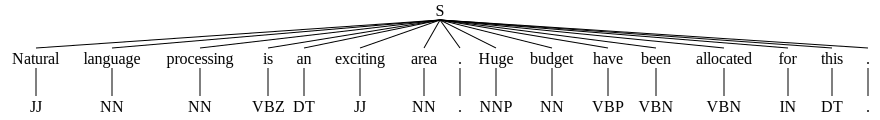

After Extracting
 (S
  (NP Natural/JJ language/NN)
  (NP processing/NN)
  (VP (V is/VBZ) (NP an/DT exciting/JJ area/NN))
  ./.
  Huge/NNP
  (NP budget/NN)
  (VP (V have/VBP))
  (VP (V been/VBN))
  (VP (V allocated/VBN))
  (P for/IN)
  this/DT
  ./.)


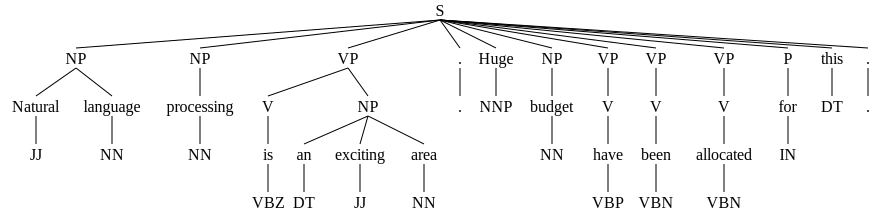

In [ ]:
# empty grammar example

# Extract all parts of speech from any text
chunker = RegexpParser("""
                    NP: {}   # To extract Noun Phrases
                    P: {}    # To extract Prepositions
                    V: {}    # To extract Verbs
                    PP: {}   # To extract Prepositional Phrases
                    VP: {}   # To extract Verb Phrases
                    """)

# Print all parts of speech in above sentence
output = chunker.parse(tagged)
print("After Extracting\n", output)


# output.draw() display error
display(output)

# another set of grammar rules:

#Extract all parts of speech from any text
chunker = RegexpParser("""
                    NP: {<DT>?<JJ>*<NN>} #To extract Noun Phrases
                    P: {<IN>}            #To extract Prepositions
                    V: {<V.*>}           #To extract Verbs
                    PP: {<p> <NP>}       #To extract Prepositional Phrases
                    VP: {<V> <NP|PP>*}   #To extract Verb Phrases
                    """)

# Print all parts of speech in above sentence
output = chunker.parse(tagged)
print("After Extracting\n", output)

# output.draw() display error
display(output)

(S (NP I) (VP (V chased) (NP (Det the) (N cat))))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


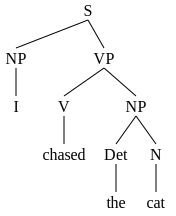

In [ ]:
import nltk
from nltk import CFG

# CFGs can not be used with english as its not as expressive.

# Define a context-free grammar
grammar = CFG.fromstring("""
    S -> NP VP
    NP -> Det N | 'I'
    VP -> V NP | V
    Det -> 'the' | 'a'
    N -> 'dog' | 'cat'
    V -> 'chased' | 'ate'
""")

# Create a recursive descent parser
parser = nltk.RecursiveDescentParser(grammar)

# Define a sentence to parse
sentence = "I chased the cat"

# Parse the sentence and print the parse trees
for tree in parser.parse(sentence.split()):
    print(tree)
    display(tree)


1. https://www.tutorialspoint.com/natural_language_processing/natural_language_processing_syntactic_analysis.htm
2. https://www.analyticsvidhya.com/blog/2022/03/syntactical-parsing-in-nlp/
3. https://intellipaat.com/blog/what-is-parsing-in-nlp/

# PyTorch

In [ ]:
import torch
import numpy as np

In [ ]:
t = torch.tensor([[1, 2, 3], [5, 2, 5]])
t

tensor([[1, 2, 3],
        [5, 2, 5]])

In [ ]:
t.t()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[1, 5],
        [2, 2],
        [3, 5]])

In [ ]:
t.shape

un_t = torch.unsqueeze(t, dim=0) # equivalent of np.expand(x, axis=0)
un_t

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([2, 3])

tensor([[[1, 2, 3],
         [5, 2, 5]]])

In [ ]:
un_t.squeeze()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[1, 2, 3],
        [5, 2, 5]])

In [ ]:
torch.sum(un_t).item()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18

In [ ]:
un_t.view(-1, 1, 1) # only one dimension can be inferred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[[1]],

        [[2]],

        [[3]],

        [[5]],

        [[2]],

        [[5]]])

In [ ]:
torch.zeros(2, 3, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [ ]:
x_ones = torch.ones_like(t) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(t, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ones Tensor: 
 tensor([[1, 1, 1],
        [1, 1, 1]]) 

Random Tensor: 
 tensor([[0.5523, 0.3378, 0.4315],
        [0.2393, 0.6719, 0.6633]]) 



In [ ]:
t = torch.tensor([[1, 1], [1, 1]])

# This computes the matrix multiplication between two tensors. y1, y2 will have the same value
y1 = t @ t.T
y2 = t.matmul(t.T)
y1
y2

# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = t * t
z2 = t.mul(t)
z1
z2

tensor([[2, 2],
        [2, 2]])

tensor([[2, 2],
        [2, 2]])

tensor([[1, 1],
        [1, 1]])

tensor([[1, 1],
        [1, 1]])

In [ ]:
t.view(1,-1)

tensor([[1, 1, 1, 1]])

In [ ]:
t.view(1,-1).squeeze()
n = t.view(1,-1).squeeze().numpy()
np.dot(n, n)

tensor([1, 1, 1, 1])

np.int64(4)

In [ ]:
t
torch.cat((t, t, t), dim=1)

tensor([[1, 1],
        [1, 1]])

tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])

In [ ]:
t
t[-1, 0:2]

tensor([[1, 1],
        [1, 1]])

tensor([1, 1])

In [ ]:
(torch.tensor([[1, 2, 0, -1]]) == 1) # masking

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ True, False, False, False]])

In [ ]:
sz=3
mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1)
mask

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

In [ ]:
mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[10., -inf, -inf],
        [10., 10., -inf],
        [10., 10., 10.]])

In [ ]:
x = [1, 2, 3]
np.where(x == 1)[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-64-1f551e9a54fd>:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(x == 1)[0]


array([], dtype=int64)

In [ ]:
torch.sigmoid(torch.tensor(5))

torch.nn.ReLU()(torch.tensor(-4))

tensor(0.9933)

tensor(0)

In [ ]:
X = torch.rand(2, 5)
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[0.0444, 0.9645, 0.4451, 0.3913, 0.8871],
        [0.4436, 0.3104, 0.9310, 0.3896, 0.4953]])

In [ ]:
probs = torch.nn.Softmax(dim=-1)(torch.tensor([[9], [10], [5]], dtype=float))
probs

probs.argmax(0)

tensor([[1.],
        [1.],
        [1.]], dtype=torch.float64)

tensor([0])

In [ ]:
# an ordered container
import torch.nn as nn

img_size = 28

# no need to define forward()
seq_modules = nn.Sequential(
    torch.nn.Flatten(),
    nn.ReLU(),
    nn.Linear(img_size * img_size, 10)
)

# 5 is probably channels I think
input_image = torch.rand(5,img_size,img_size)
logits = seq_modules(input_image)
logits.shape

torch.Size([5, 10])

In [ ]:
linear_layer = nn.Linear(4, 1)
for x in linear_layer.named_parameters():
  print('---------')
  print(x[0], x[1].numel())

---------
weight 4
---------
bias 1


In [ ]:
seq_modules = nn.Sequential(
    nn.Linear(3, 2),
    nn.Linear(2, 1)
)
for x in seq_modules.named_parameters():
  print('---------')
  print(x[0], x[1].numel())

---------
0.weight 6
---------
0.bias 2
---------
1.weight 2
---------
1.bias 1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# can use within collate_fn in dataloader
import torch
from torch.nn.utils.rnn import pad_sequence

# Example list of sequences with varying lengths
sequences = [torch.tensor([1, 2, 3], dtype=torch.float),
             torch.tensor([4, 5], dtype=torch.float),
             torch.tensor([6], dtype=torch.float)]

# Pad the sequences
padded_sequence = pad_sequence(sequences, batch_first=True, padding_value=0.0)
padded_sequence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[1., 2., 3.],
        [4., 5., 0.],
        [6., 0., 0.]])

In [ ]:
# serves different purpose.
# ignores pad values and leads to better memory utilization

import torch
from torch.nn.utils.rnn import pack_padded_sequence

lengths = torch.tensor([len(t) for t in padded_sequence])

# Pack the padded sequence
packed_sequence = pack_padded_sequence(padded_sequence, lengths, batch_first=True)
packed_sequence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PackedSequence(data=tensor([1., 4., 6., 2., 5., 0., 3., 0., 0.]), batch_sizes=tensor([3, 3, 3]), sorted_indices=None, unsorted_indices=None)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# can't use tensordataset directly for variable input lengths
# need to implement class

# can't init tensor on variable. otherwise, just init as tensor and use tensordataset
X = [[1, 2, 3], [5, 7], [5]]

# needed
X = list(map(torch.tensor, X))

y = torch.tensor([0, 1, 1])

# can't use for variable
#dataset = TensorDataset(X, y)

class SequenceDataset(Dataset): # just a protocol class so doesn't inherit anythinmg no super()
  def __init__(self, sequences, labels):
    self.sequences = sequences
    self.labels = labels

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.labels[idx]

dataset = SequenceDataset(X, y)

def collate_fn(batch):
  sequences, labels = zip(*batch)
  lengths = [len(seq) for seq in sequences]
  padded = pad_sequence(sequences, batch_first=True, padding_value=0)
  return padded, lengths, labels

dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn)

# Iterate through DataLoader
for batch in dataloader:
    padded_sequences, lengths, labels = batch
    print("Padded Sequences:\n", padded_sequences)
    print("Lengths:\n", lengths)
    print("Labels:\n", labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Padded Sequences:
 tensor([[1, 2, 3],
        [5, 7, 0]])
Lengths:
 [3, 2]
Labels:
 (tensor(0), tensor(1))
Padded Sequences:
 tensor([[5]])
Lengths:
 [1]
Labels:
 (tensor(1),)


## Streaming Data

Can also use pandas(chunk_size) or maybe using numpy.

---



In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

file = 'example6.h5'

# Create an HDF5 file
with h5py.File(file, 'w') as f:
    f.create_dataset('data', data=np.arange(100), compression="gzip")
    f.create_dataset('labels', data=np.random.randint(0, 3, size=(100,)), compression="gzip")

class HDF5Dataset(Dataset):
    def __init__(self, h5_file):
        self.file = h5_file
        self.dataset = h5py.File(h5_file, 'r')
        self.data = self.dataset['data']
        self.labels = self.dataset['labels']
        #self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# Usage example
h5_file = file
dataset = HDF5Dataset(h5_file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<HDF5 dataset "data": shape (100,), type "<i8">

<HDF5 dataset "labels": shape (100,), type "<i8">

In [ ]:
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

# Iterate over DataLoader in training loop
for inputs, labels in data_loader:
    # Perform training step
    print(inputs)
    print('===========')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([72., 94., 85., 61.,  8., 16., 74., 62., 20., 56., 96., 81., 14., 71.,
        67., 64., 68., 57., 39., 41.,  3., 59.,  1., 31., 77., 19., 66., 50.,
        21., 28., 58.,  0.])
tensor([ 5., 17., 51., 99., 95., 91., 48., 33., 79., 70., 78., 90., 27., 30.,
        44., 55., 73., 83., 23., 18., 86., 24., 63., 25., 32., 45., 87., 34.,
        11., 75.,  2., 80.])
tensor([13.,  7., 97., 38., 92., 89., 54., 10., 15., 82., 26., 60., 40., 12.,
         6., 76., 69., 37., 36.,  4., 98., 88., 42., 52., 93., 49., 43., 53.,
        22., 47., 84., 65.])
tensor([46., 29., 35.,  9.])


## CBOW in PyTroch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import numpy as np

# Sample data
corpus = [
    "he is the king",
    "the king is royal",
    "she is the queen",
    "the queen is royal",
    "royal is nice",
    "she is nice"
]

# Tokenize corpus
words = set()
for sentence in corpus:
    for word in sentence.split():
      words.add(word)

#print([word for sent in corpus for word in sent.split(' ')])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#word_counts = Counter(words)
vocab = {word: idx for idx, word in enumerate(words)}
idx_to_word = {idx: word for word, idx in vocab.items()}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# CBOW Dataset
class CBOWDataset(Dataset):
    def __init__(self, corpus, window_size=2):
        self.corpus = corpus
        self.window_size = window_size
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for sentence in self.corpus:
            words = sentence.split()
            for i, target_word in enumerate(words):
                context = [words[j] for j in range(max(0, i - self.window_size), min(len(words), i + self.window_size + 1)) if j != i]
                data.append((context, target_word))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target_word = self.data[idx]
        context_idx = [vocab[word] for word in context]
        target_idx = vocab[target_word]
        return torch.tensor(context_idx), torch.tensor(target_idx)

# CBOW Model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)  # Average embedding of context words
        x = self.linear(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Training parameters
vocab_size = len(vocab)
embedding_dim = 5
window_size = 2
batch_size = 4
lr = 0.01
num_epochs = 10

# Create dataset and dataloader
dataset = CBOWDataset(corpus, window_size=window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = CBOW(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CBOW(
  (embedding): Embedding(8, 5)
  (linear): Linear(in_features=5, out_features=8, bias=True)
)

In [ ]:
model.embedding.weight

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Parameter containing:
tensor([[-1.1160, -0.4899,  0.2274, -1.5028, -0.6685],
        [ 0.8415, -1.0474,  0.8950, -0.0022, -0.3813],
        [ 0.4222,  0.9556, -0.1896,  0.1746,  0.3745],
        [ 0.8796,  0.8799, -0.7767,  0.9415, -0.6332],
        [ 2.1625, -1.2053,  0.0026, -0.4953,  0.8557],
        [ 2.0018,  0.6339,  1.0876, -2.1512,  0.8558],
        [ 0.3649, -1.0374, -1.6773,  0.4491,  0.3523],
        [ 0.7458, -1.0501,  0.2714,  1.5829, -0.6661]], requires_grad=True)

In [ ]:
# Get word embeddings
word_embeddings = model.embedding.weight.detach().numpy()

# Print word embeddings
for idx, word in idx_to_word.items():
    print(f"{word}: {word_embeddings[idx]}")


king: [-1.1159676  -0.48994532  0.22737613 -1.5027516  -0.6684592 ]
queen: [ 0.8414821  -1.0473682   0.8950346  -0.00221192 -0.38132346]
the: [ 0.42217904  0.9556126  -0.18964411  0.17457695  0.374534  ]
nice: [ 0.87963414  0.87990624 -0.77670836  0.94145584 -0.63320166]
royal: [ 2.1624844  -1.2053202   0.00262507 -0.49533412  0.85569453]
is: [ 2.001756    0.63385695  1.0876482  -2.1512113   0.85579574]
she: [ 0.36486816 -1.0373968  -1.6773473   0.44908097  0.35231712]
he: [ 0.74577373 -1.050102    0.2714224   1.5828917  -0.6661278 ]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Regression with RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example data: a sequence of numbers
data = torch.arange(1, 11, dtype=torch.float32).view(-1, 1)
sequence_length = 3  # Length of each sequence
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])

In [ ]:
def create_inout_sequences(input_data, seq_length):
    inout_seq = []
    L = len(input_data)
    for i in range(L-seq_length):
        seq = input_data[i:i+seq_length]
        label = input_data[i+seq_length:i+seq_length+1]
        inout_seq.append((seq, label))
    return inout_seq

seq_data = create_inout_sequences(data, sequence_length)
for seq, labels in seq_data:
  print(seq, labels)
  break

tensor([[1.],
        [2.],
        [3.]]) tensor([[4.]])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Initial hidden state

        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step
        # according to chatgpt
        # this equals
        # out = self.fc(hn.squeeze(0))  # Using hn instead of out[:, -1, :]
        # i dont think its true for bidirectional coz output has last layer only (all t).
        # h as last time step (both layers)

        # a single number
        return out

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the Model
epochs = 100
for epoch in range(epochs):
    for seq, labels in seq_data:
        optimizer.zero_grad()
        y_pred = model(seq.unsqueeze(0))  # Add batch dimension
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 0, Loss: 75.97752380371094
Epoch 10, Loss: 12.765766143798828
Epoch 20, Loss: 7.616011619567871
Epoch 30, Loss: 2.254009962081909
Epoch 40, Loss: 0.9366371035575867
Epoch 50, Loss: 0.42715272307395935
Epoch 60, Loss: 0.1998358815908432
Epoch 70, Loss: 0.10094868391752243
Epoch 80, Loss: 0.07928889244794846
Epoch 90, Loss: 0.050036802887916565


## Language Generation with RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import random

# Define constants
START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"
BATCH_SIZE = 2
NUM_EPOCHS = 10
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

# Define dataset class
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Function to build vocabulary and tokenizer
def build_vocab_and_tokenizer(data):
    words = [word for sentence in data for word in sentence.split()]
    word_counts = Counter(words)
    vocab = [word for word, count in word_counts.items()]
    vocab.append(START_TOKEN)
    vocab.append(END_TOKEN)
    vocab.append(PAD_TOKEN)
    tokenizer = {word: idx for idx, word in enumerate(vocab)}
    return vocab, tokenizer

# Function to convert text to tensor indices
def text_to_tensor(text, tokenizer):
    tensor = [tokenizer.get(word, tokenizer[PAD_TOKEN]) for word in text.split()]
    return tensor

# Custom collate function to handle variable length sequences
def collate_fn(batch):
    texts = [item for item in batch]
    tensor_texts = [torch.LongTensor(text_to_tensor(text, tokenizer)) for text in texts]
    padded_texts = pad_sequence(tensor_texts, batch_first=True, padding_value=tokenizer[PAD_TOKEN])
    return padded_texts

# Define the RNN model
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(RNNLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        print('Batch size: ', x.size())
        embedded = self.embedding(x)
        print('Embeddings size: ', embedded.size())

        output, _ = self.rnn(embedded)
        print('Output: ', output.size())
        output = self.fc(output)
        print('Final size: ', output.size())

        # i think outputting all because we are modelling language at each step
        return output

# Prepare data
data = docs.copy() # from above

# Split data into train and test
random.shuffle(data)
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Build vocabulary and tokenizer
vocab, tokenizer = build_vocab_and_tokenizer(train_data)

# Define datasets and dataloaders
train_dataset = TextDataset(train_data)
test_dataset = TextDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize model, loss function, and optimizer
model = RNNLanguageModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch[:, :-1])  # Ignore the last token
        target = batch[:, 1:]  # Predict next token

        # all tokens of entire batch contribute to loss
        loss = criterion(output.reshape(-1, len(vocab)), target.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader)}")

# Evaluation loop
model.eval()
total_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        output = model(batch[:, :-1])  # Ignore the last token
        target = batch[:, 1:]  # Predict next token
        loss = criterion(output.reshape(-1, len(vocab)), target.reshape(-1))
        total_loss += loss.item()
print(f"Test Loss: {total_loss/len(test_loader)}")

# Inference function
def generate_text(model, tokenizer, max_length=20):
    model.eval()
    current_token = tokenizer[START_TOKEN]
    generated_text = [current_token]
    while len(generated_text) < max_length:
        input_tensor = torch.LongTensor([[current_token]])
        output = model(input_tensor)
        probabilities = torch.softmax(output[0, -1], dim=0)
        next_token = torch.multinomial(probabilities, num_samples=1).item()
        if next_token == tokenizer[END_TOKEN]:
            break
        generated_text.append(next_token)
        current_token = next_token
    return ' '.join([vocab[token] for token in generated_text])

# Generate text
generated_text = generate_text(model, tokenizer, max_length=20)
print("Generated Text:", generated_text)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 1, Train Loss: 4.144920825958252


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 2, Train Loss: 3.895688772201538


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Epoch 3, Train Loss: 3.716145634651184


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 4, Train Loss: 3.5171313285827637


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 5, Train Loss: 3.315058469772339


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Epoch 6, Train Loss: 3.1272069215774536


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 7, Train Loss: 2.9433690309524536


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 8, Train Loss: 2.758808970451355


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Epoch 9, Train Loss: 2.5313172340393066


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([2, 18])
Embeddings size:  torch.Size([2, 18, 100])
Output:  torch.Size([2, 18, 128])
Final size:  torch.Size([2, 18, 59])
Batch size:  torch.Size([2, 15])
Embeddings size:  torch.Size([2, 15, 100])
Output:  torch.Size([2, 15, 128])
Final size:  torch.Size([2, 15, 59])
Epoch 10, Train Loss: 2.4061310291290283


RNNLanguageModel(
  (embedding): Embedding(59, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=59, bias=True)
)

Batch size:  torch.Size([1, 14])
Embeddings size:  torch.Size([1, 14, 100])
Output:  torch.Size([1, 14, 128])
Final size:  torch.Size([1, 14, 59])
Test Loss: 2.629478693008423
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Final size:  torch.Size([1, 1, 59])
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Final size:  torch.Size([1, 1, 59])
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Final size:  torch.Size([1, 1, 59])
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Final size:  torch.Size([1, 1, 59])
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Final size:  torch.Size([1, 1, 59])
Batch size:  torch.Size([1, 1])
Embeddings size:  torch.Size([1, 1, 100])
Output:  torch.Size([1, 1, 128])
Fi

## GRU for Text Generation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

START_TOKEN = "<START>"
END_TOKEN = "<END>"
PAD_TOKEN = "<PAD>"


# Define the dataset
class LanguageDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Function to tokenize the text and build vocabulary
def build_vocab(texts):
    vocab = set()
    for text in texts:
        vocab.update(text.split())
    vocab = list(vocab)
    vocab.append(START_TOKEN)
    vocab.append(END_TOKEN)
    vocab.append(PAD_TOKEN)
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word_to_idx, idx_to_word

# Function to encode text into tensor sequence
def encode_text(text, word_to_idx):
    return torch.tensor([word_to_idx[word] for word in text.split()])

# Function to decode tensor sequence into text
def decode_sequence(sequence, idx_to_word):
    return ' '.join([idx_to_word[idx.item()] for idx in sequence])

# Define the GRU language model
class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRULanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output)
        return output

# Function to handle variable length sequences in DataLoader
def collate_fn(batch):
    texts = [item for item in batch]
    encoded_texts = [encode_text(text, word_to_idx) for text in texts]
    padded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=PAD_IDX)
    return padded_texts

# Define training and evaluation loop
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs = batch[:, :-1]
            targets = batch[:, 1:]
            outputs = model(inputs)
            loss = criterion(outputs.permute(0, 2, 1), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# Define generator function for inference
def generate_text(model, start_token_idx, end_token_idx, max_length):
    model.eval()
    with torch.no_grad():
        current_token = torch.tensor([start_token_idx]).unsqueeze(0)
        generated_text = []
        while len(generated_text) < max_length:
            output_probs = model(current_token)

            # use logits of the last elemet in the sequence
            _, next_token = torch.max(output_probs[:, -1, :], dim=1)
            if next_token.item() == end_token_idx:
                break
            generated_text.append(next_token.item())
            current_token = torch.cat((current_token, next_token.unsqueeze(0)), dim=1)
        return generated_text

# Example usage
texts = docs.copy()#["This is an example text.", "Another example text."]
vocab, word_to_idx, idx_to_word = build_vocab(texts)
PAD_IDX = len(vocab)
vocab_size = len(vocab) + 1
embedding_dim = 100
hidden_dim = 128
start_token_idx = vocab.index('<START>')
end_token_idx = vocab.index('<END>')
max_length = 5

dataset = LanguageDataset(texts)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

model = GRULanguageModel(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, num_epochs=10)

generated_text = generate_text(model, start_token_idx, end_token_idx, max_length)
print(decode_sequence(torch.tensor(generated_text), idx_to_word))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/10, Loss: 4.211387634277344
Epoch 2/10, Loss: 4.061304330825806
Epoch 3/10, Loss: 3.923961639404297
Epoch 4/10, Loss: 3.796614170074463
Epoch 5/10, Loss: 3.659853935241699
Epoch 6/10, Loss: 3.5301506519317627
Epoch 7/10, Loss: 3.386394739151001
Epoch 8/10, Loss: 3.251697063446045
Epoch 9/10, Loss: 3.1070022583007812
Epoch 10/10, Loss: 2.955905795097351
81-story building. City visitors, with


## Another GRU for Text Generation (duplicated)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# Define your dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # no labels coz self-supervised
        return self.data[idx]

# Define your model architecture
class MyModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        print('Embedding size: ', embedded.size())
        output, hidden = self.gru(embedded, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        # 1 = n_layers
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

# Define your data processing functions
def build_vocab(data):
    word_counter = Counter()
    for sentence in data:
        word_counter.update(sentence.split())
    vocab = ['<pad>', '<start>', '<end>', '<unk>'] + [word for word, _ in word_counter.most_common()]
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return vocab, word2idx, idx2word

def encode_sentence(sentence, word2idx):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def collate_fn(batch):
    sentences = [torch.LongTensor(item) for item in batch]
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded_sentences

# Define your training loop
def train(model, train_loader, criterion, optimizer, batch_size, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs = batch[:, :-1].to(device)
        targets = batch[:, 1:].to(device)
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        outputs, _ = model(inputs, hidden)
        loss = criterion(outputs.view(-1, outputs.size(2)), targets.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Define your evaluation loop
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)
            hidden = model.init_hidden(len(batch))
            outputs, _ = model(inputs, hidden)
            loss = criterion(outputs.view(-1, outputs.size(2)), targets.contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Define your inference function
def generate_sentence(model, start_token_idx, end_token_idx, max_length, batch_size, device):
    model.eval()
    with torch.no_grad():
        current_token_idx = start_token_idx
        sentence = [current_token_idx]
        hidden = model.init_hidden(1)
        for _ in range(max_length):
            inputs = torch.LongTensor([[current_token_idx]]).to(device)
            outputs, hidden = model(inputs, hidden)
            predicted_token_idx = outputs.argmax().item()
            if predicted_token_idx == end_token_idx:
                break
            sentence.append(predicted_token_idx)
            current_token_idx = predicted_token_idx
    return sentence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Example usage
#data = ['<start> hello how are you <end>', '<start> i am fine thank you <end>']
data = docs.copy()
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

vocab, word2idx, idx2word = build_vocab(train_data)
train_data_encoded = [encode_sentence(sentence, word2idx) for sentence in train_data]
val_data_encoded = [encode_sentence(sentence, word2idx) for sentence in val_data]

train_dataset = MyDataset(train_data_encoded)
val_dataset = MyDataset(val_data_encoded)

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel(vocab_size=len(vocab), embed_size=50, hidden_size=100)
model.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MyModel(
  (embedding): Embedding(56, 50)
  (gru): GRU(50, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=56, bias=True)
)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, batch_size, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Example inference
start_token_idx = word2idx['<start>']
end_token_idx = word2idx['<end>']
generated_sentence = generate_sentence(model, start_token_idx, end_token_idx, 10, batch_size, device)
generated_sentence = ' '.join([idx2word[idx] for idx in generated_sentence])
print(generated_sentence)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Embedding size:  torch.Size([2, 18, 50])
Embedding size:  torch.Size([2, 15, 50])
Embedding size:  torch.Size([1, 13, 50])
Epoch [1/5], Train Loss: 4.0238, Val Loss: 4.1578
Embedding size:  torch.Size([2, 18, 50])
Embedding size:  torch.Size([2, 15, 50])
Embedding size:  torch.Size([1, 13, 50])
Epoch [2/5], Train Loss: 4.0238, Val Loss: 4.1578
Embedding size:  torch.Size([2, 18, 50])
Embedding size:  torch.Size([2, 15, 50])
Embedding size:  torch.Size([1, 13, 50])
Epoch [3/5], Train Loss: 4.0238, Val Loss: 4.1578
Embedding size:  torch.Size([2, 18, 50])
Embedding size:  torch.Size([2, 15, 50])
Embedding size:  torch.Size([1, 13, 50])
Epoch [4/5], Train Loss: 4.0238, Val Loss: 4.1578
Embedding size:  torch.Size([2, 18, 50])
Embedding size:  torch.Size([2, 15, 50])
Embedding size:  torch.Size([1, 13, 50])
Epoch [5/5], Train Loss: 4.0238, Val Loss: 4.1578
Embedding size:  torch.Size([1, 1, 50])
Embedding size:  torch.Size([1, 1, 50])
Embedding size:  torch.Size([1, 1, 50])
Embedding size:

## LSTM for Sentiment Analysis

In [ ]:
import pandas as pd

# IMDb reviews data as a dictionary
imdb_reviews = {
    "review": [
        "The Shawshank Redemption is an incredible movie. The acting is superb and the storyline is captivating.",
        "I found the plot to be confusing and the acting to be mediocre. Overall, I was disappointed with the film.",
        "Great movie! The special effects were amazing and the characters were well-developed.",
        "The dialogue felt forced and unrealistic. I couldn't connect with any of the characters.",
        "The Godfather is a masterpiece. The performances are outstanding and the direction is flawless.",
        "The pacing of the film was too slow, and I found myself losing interest halfway through.",
        "Titanic is a classic love story that will tug at your heartstrings. I highly recommend it.",
        "The acting was wooden and the plot was predictable. I was not impressed.",
        "Jurassic Park is a thrilling adventure that keeps you on the edge of your seat from start to finish.",
        "I felt the movie lacked depth and the characters were one-dimensional. Overall, it was underwhelming."
    ],
    "sentiment": [
        "positive",
        "negative",
        "positive",
        "negative",
        "positive",
        "negative",
        "positive",
        "negative",
        "positive",
        "negative"
    ]
}

df = pd.DataFrame(imdb_reviews)
df = pd.concat([df, df]).reset_index(drop=True)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,sentiment
0,The Shawshank Redemption is an incredible movi...,positive
1,I found the plot to be confusing and the actin...,negative
2,Great movie! The special effects were amazing ...,positive
3,The dialogue felt forced and unrealistic. I co...,negative
4,The Godfather is a masterpiece. The performanc...,positive
5,"The pacing of the film was too slow, and I fou...",negative
6,Titanic is a classic love story that will tug ...,positive
7,The acting was wooden and the plot was predict...,negative
8,Jurassic Park is a thrilling adventure that ke...,positive
9,I felt the movie lacked depth and the characte...,negative


In [ ]:
X, y = df['review'], df['sentiment']

from sklearn.model_selection import train_test_split

# can also use random_split() by torch on top of pytorch's dataset
# like: train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_train.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
sentiment,
positive,9
negative,7


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
import string

def preprocess_word(w):
    return w.lower()

def build_vocab(X_train):
    stop_words = set(stopwords.words('english'))
    word_list = set()

    # Building the vocabulary
    for sent in X_train:
        for word in sent.lower().split():
            word = preprocess_word(word)
            if word not in stop_words and word != '' and word not in string.punctuation:
                word_list.add(word)

    vocab = {w: i for i, w in enumerate(word_list)}
    return vocab

def tokenize(sentences):
    tokenized_list = []
    for sent in sentences:
        tokenized_words = [vocab[preprocess_word(w)] for w in sent.lower().split() if preprocess_word(w) in vocab]
        if len(tokenized_words) == 0:
          print(sent)
          continue
        tokenized_list.append(torch.tensor(tokenized_words))
    return tokenized_list

def encode_labels(labels):
  return torch.tensor([1 if label == 'positive' else 0 for label in labels])


def preprocess(X, y):
    tokenized_text = tokenize(X.values)
    encoded_labels = encode_labels(y.values)
    return tokenized_text, encoded_labels

vocab = build_vocab(X_train)

# Tokenize/encode
X_train_tokenized, y_train_tokenized = preprocess(X_train, y_train)
X_test_tokenized, y_test_tokenized = preprocess(X_test, y_test)

print(X_train_tokenized)
print(y_train_tokenized)
print(X_test_tokenized)
print(y_test_tokenized)

[tensor([15, 50, 65, 10, 42,  9, 58, 47, 41]), tensor([27, 44, 52, 26, 40, 48]), tensor([ 6, 29, 16, 39, 59, 33, 28, 14]), tensor([61, 60, 53, 62, 43, 35, 49,  3]), tensor([54,  8, 30,  0,  1, 55, 63,  5]), tensor([31,  6, 38,  4, 19, 32]), tensor([ 0, 56, 22, 43, 21, 28, 34, 13]), tensor([15, 50, 65, 10, 42,  9, 58, 47, 41]), tensor([37, 66, 57, 45, 20, 59, 11]), tensor([43, 17, 56, 36, 64]), tensor([ 6, 29, 16, 39, 59, 33, 28, 14]), tensor([54,  8, 30,  0,  1, 55, 63,  5]), tensor([37, 66, 57, 45, 20, 59, 11]), tensor([ 7, 24, 51, 23, 46, 25,  2, 18, 12]), tensor([ 7, 24, 51, 23, 46, 25,  2, 18, 12]), tensor([27, 44, 52, 26, 40, 48])]
tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1])
[tensor([43, 17, 56, 36, 64]), tensor([ 0, 56, 22, 43, 21, 28, 34, 13]), tensor([31,  6, 38,  4, 19, 32]), tensor([61, 60, 53, 62, 43, 35, 49,  3])]
tensor([0, 0, 0, 1])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset

# create Tensor datasets

# using custom class for variable input
train_data = SequenceDataset(X_train_tokenized, y_train_tokenized)
valid_data = SequenceDataset(X_test_tokenized, y_test_tokenized)

# dataloaders
batch_size = 2

def collate_fn(batch):
    sentences, labels = zip(*batch)
    lengths = [len(sent) for sent in sentences]
    padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_lengths, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)
print('Sample sample_lengths: \n', sample_lengths)

Sample input size:  torch.Size([2, 9])
Sample input: 
 tensor([[ 6, 29, 16, 39, 59, 33, 28, 14,  0],
        [15, 50, 65, 10, 42,  9, 58, 47, 41]])
Sample output: 
 tensor([0, 1])
Sample sample_lengths: 
 tensor([8, 9])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cpu')

In [ ]:
class SentimentRNN(torch.nn.Module):
    def __init__(self, no_layers, vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        #lstm: DOES NOT DEPEND ON SEQUENCE LENGTH. SHARED WEIGHTS.
        self.lstm = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=no_layers,
            batch_first=True #bidirectional=True
        )

        # dropout layer
        self.dropout = torch.nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = torch.nn.Linear(self.hidden_dim, output_dim) # *2 because of bidirectional
        self.sig = torch.nn.Sigmoid()

    def forward(self, x, lengths, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True

        # using packed sequences
        packed_embed = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)

        # handles feedback loop and processes all the tokens in a sequence
        lstm_out, hidden = self.lstm(packed_embed, hidden)

        # for BILSTM: concatenate the final forward and backward hidden states
        # forward even indices, backward odd`
        # hidden_concat = torch.cat((hidden[0][-2, :, :], hidden[0][-1, :, :]), dim=1)

        # Unpack the PackedSequence
        lstm_out, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        """
        Reshapes the lstm_out tensor to have shape (batch_size * sequence_length, hidden_dim).
        The -1 is a placeholder that infers the appropriate size automatically based on the
        other dimension (hidden_dim). This essentially flattens the tensor so that each time step
        for each batch item is treated as an independent sample.
        """

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get element of each batch I guess

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM

        # twice layers for BILSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

    # optionally:
    # def init_weights(self):
    #     for param in self.parameters():
    #         nn.init.kaiming_uniform_(param, a=math.sqrt(5))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 # extra 1 for padding????
embedding_dim = 64
output_dim = 1
hidden_dim = 12

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.5)
model.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}\n")

Layer: embedding.weight | Size: torch.Size([68, 64])

Layer: lstm.weight_ih_l0 | Size: torch.Size([48, 64])

Layer: lstm.weight_hh_l0 | Size: torch.Size([48, 12])

Layer: lstm.bias_ih_l0 | Size: torch.Size([48])

Layer: lstm.bias_hh_l0 | Size: torch.Size([48])

Layer: lstm.weight_ih_l1 | Size: torch.Size([48, 12])

Layer: lstm.weight_hh_l1 | Size: torch.Size([48, 12])

Layer: lstm.bias_ih_l1 | Size: torch.Size([48])

Layer: lstm.bias_hh_l1 | Size: torch.Size([48])

Layer: fc.weight | Size: torch.Size([1, 12])

Layer: fc.bias | Size: torch.Size([1])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# function to calculate correct labels
def acc(pred,label):
    # simple way to convert probs into classes
    pred = torch.round(pred.squeeze())

    # count correct predictions
    return torch.sum(pred == label.squeeze()).item()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
clip = 5 # gradient clipping for exploding gradients
epochs = 5
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    # layers like dropout are enabled. gradients ar eclcualed. batch normalziation uses batch statistics.
    model.train()

    for inputs, lengths, labels in train_loader:
        # move to GPU
        inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        # h = tuple([each.data for each in h])

        # why not just init wihtin the loop
        # initialize hidden states and cell states of LSTM
        h = model.init_hidden(batch_size)

        # clear grad to prevent gradient accumulation across batches.
        model.zero_grad()

        # forward() pass. maintain operations gradient functions in DAG .grad_fn
        output, _ = model(inputs, lengths, h)  # h not used outside

        # calculate the loss
        loss = criterion(output, labels.float())
        train_losses.append(loss.item())

        # calculate gradients through backpropagation into .grad, applies chain rule
        loss.backward()

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update weights
        optimizer.step()

        # calculating accuracy (correct labels)
        accuracy = acc(output, labels)
        train_acc += accuracy # actually correct predictions


    val_losses = []
    val_acc = 0.0

    # disable some operations
    model.eval()

    # no gradient calculations needed
    with torch.no_grad():
      for inputs, lengths, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        #val_h = tuple([each.data for each in val_h])
        val_h = model.init_hidden(batch_size)

        output, val_h = model(inputs, lengths, val_h)

        val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.item())
        accuracy = acc(output,labels)
        val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

tensor(0.4476)

tensor(0.6162)

tensor(0.4798)

tensor(0.7009)

tensor(0.6145)

tensor(0.4382)

tensor(0.5129)

tensor(0.2409)

SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

Epoch 1
train_loss : 0.6941387727856636 val_loss : 0.773928314447403
train_accuracy : 56.25 val_accuracy : 25.0
Validation loss decreased (inf --> 0.773928).  Saving model ...


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

tensor(0.4518)

tensor(0.1779)

tensor(0.4610)

tensor(0.6086)

tensor(0.1610)

tensor(0.1773)

tensor(0.1664)

tensor(0.2073)

SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

Epoch 2
train_loss : 0.6831552758812904 val_loss : 0.773928314447403
train_accuracy : 56.25 val_accuracy : 25.0
Validation loss decreased (0.773928 --> 0.773928).  Saving model ...


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

tensor(0.1702)

tensor(0.6227)

tensor(0.4421)

tensor(0.1707)

tensor(0.1527)

tensor(0.6879)

tensor(0.4503)

tensor(0.4580)

SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

Epoch 3
train_loss : 0.6816720142960548 val_loss : 0.773928314447403
train_accuracy : 56.25 val_accuracy : 25.0
Validation loss decreased (0.773928 --> 0.773928).  Saving model ...


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

tensor(0.4483)

tensor(0.1257)

tensor(0.1633)

tensor(0.6750)

tensor(0.4350)

tensor(0.1389)

tensor(0.1874)

tensor(0.1560)

SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

Epoch 4
train_loss : 0.6783403530716896 val_loss : 0.773928314447403
train_accuracy : 56.25 val_accuracy : 25.0
Validation loss decreased (0.773928 --> 0.773928).  Saving model ...


SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

tensor(0.6061)

tensor(0.1477)

tensor(0.1427)

tensor(0.2125)

tensor(0.4471)

tensor(0.1575)

tensor(0.4799)

tensor(0.2103)

SentimentRNN(
  (embedding): Embedding(68, 64)
  (lstm): LSTM(64, 12, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=12, out_features=1, bias=True)
  (sig): Sigmoid()
)

Epoch 5
train_loss : 0.6770043671131134 val_loss : 0.773928314447403
train_accuracy : 56.25 val_accuracy : 25.0
Validation loss decreased (0.773928 --> 0.773928).  Saving model ...


In [ ]:
def predict_text(text):
  model.eval()

  word_seq = np.array([vocab[preprocess_word(word)] for word in text.split() if preprocess_word(word) in vocab])
  length = torch.tensor([len(word_seq)])
  word_seq = np.expand_dims(word_seq, axis=0)
  inputs = torch.from_numpy(word_seq).to(device)
  batch_size = 1
  h = model.init_hidden(batch_size)
  # h = tuple([each.data for each in h]) # maybe unnecessary
  with torch.no_grad():
    output, h = model(inputs, length, h)
  probability = output.item()
  return probability

index = 0
predict_text('this movie sucks.')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.579501211643219

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## CNN for Sentiment Analysis

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split

# Sample data
texts = [
    "I love this movie",
    "This film was terrible",
    "Absolutely fantastic",
    "Worst movie ever",
    "I enjoyed it",
    "Not my favorite",
    "Best movie I have seen",
    "Could be better",
    "I would watch it again",
    "Awful experience"
]

labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1 for positive, 0 for negative

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization
tokenized_train_texts = [text.split() for text in train_texts]

# Vocabulary creation
train_vocab = Counter(itertools.chain(*tokenized_train_texts))
train_vocab = {word: i + 2 for i, (word, _) in enumerate(train_vocab.most_common())}  # Start indices from 2

# I don't think this info is needed for tasks other than langauge modelling
train_vocab['<PAD>'] = 0
train_vocab['<UNK>'] = 1

# Convert texts to sequences of indices
def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in text]

# Padding
def pad_sequence(seq, max_len):
    return seq + [train_vocab['<PAD>']] * (max_len - len(seq))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.data = sequences
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    print('Batch: ')
    print(batch)
    print('Unpacked:')
    print(*batch)
    print('Zipped:')
    print(zip(*batch))
    texts, labels = zip(*batch)
    sequences = [pad_sequence(text, max_len) for text in texts]
    return torch.tensor(sequences, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


train_sequences = [text_to_sequence(text, train_vocab) for text in tokenized_train_texts]
max_len = max(len(seq) for seq in train_sequences)
train_dataset = SentimentDataset(train_sequences, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
for batch in train_dataloader:
  tokens, labels = batch
  print(tokens, labels)
  break

Batch: 
[([12, 13], 1), ([2, 7, 8, 3], 1)]
Unpacked:
([12, 13], 1) ([2, 7, 8, 3], 1)
Zipped:
tensor([[12, 13,  0,  0,  0],
        [ 2,  7,  8,  3,  0]]) tensor([1, 1])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class SimpleCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SimpleCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # treat embedding dimension as in_channels, kernel size is just a window for context words
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=50, kernel_size=3)  # 50 filters, kernel size 3
        self.fc = nn.Linear(50 * (max_len - 3 + 1), num_classes)  # Fully connected layer

    def forward(self, x):
        # x: (batch_size, max_len)
        x = self.embedding(x)  # (batch_size, max_len, embed_dim)
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, embed_dim, max_len)
        x = F.relu(self.conv(x))  # Apply convolution: (batch_size, 50, max_len-3+1)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 50 * (max_len-3+1))
        x = self.fc(x)  # Fully connected layer: (batch_size, num_classes)
        return x

vocab_size = len(train_vocab)
embed_dim = 50  # Reduced embedding dimension for simplicity
num_classes = 2

model = SimpleCNNModel(vocab_size, embed_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print('==='*50)
    for batch_data, batch_labels in train_dataloader:
        outputs = model(batch_data)  # logits
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Sample inference
sample_text = "I really love this movie"
sample_sequence = text_to_sequence(sample_text.split(), train_vocab)
sample_sequence_padded = pad_sequence(sample_sequence, max_len)
sample_data = torch.tensor([sample_sequence_padded], dtype=torch.long)
output = model(sample_data)  # logits

print(output)

_, predicted = torch.max(output, 1)
print(f'Predicted: {predicted.item()}')

Batch: 
[([2, 7, 8, 3], 1), ([20, 3, 2, 21, 22], 1)]
Unpacked:
([2, 7, 8, 3], 1) ([20, 3, 2, 21, 22], 1)
Zipped:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Batch: 
[([14, 15], 0), ([9, 10, 11], 0)]
Unpacked:
([14, 15], 0) ([9, 10, 11], 0)
Zipped:
Batch: 
[([12, 13], 1), ([4, 5, 6], 0)]
Unpacked:
([12, 13], 1) ([4, 5, 6], 0)
Zipped:
Batch: 
[([18, 3, 19], 0), ([2, 16, 17], 1)]
Unpacked:
([18, 3, 19], 0) ([2, 16, 17], 1)
Zipped:
Epoch [1/2], Loss: 0.8213
Batch: 
[([4, 5, 6], 0), ([2, 7, 8, 3], 1)]
Unpacked:
([4, 5, 6], 0) ([2, 7, 8, 3], 1)
Zipped:
Batch: 
[([2, 16, 17], 1), ([20, 3, 2, 21, 22], 1)]
Unpacked:
([2, 16, 17], 1) ([20, 3, 2, 21, 22], 1)
Zipped:
Batch: 
[([18, 3, 19], 0), ([9, 10, 11], 0)]
Unpacked:
([18, 3, 19], 0) ([9, 10, 11], 0)
Zipped:
Batch: 
[([12, 13], 1), ([14, 15], 0)]
Unpacked:
([12, 13], 1) ([14, 15], 0)
Zipped:
Epoch [2/2], Loss: 0.6567
tensor([[-0.3525,  0.1536]], grad_fn=<AddmmBackward0>)
Predicted: 1


In [ ]:
#

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pipeline / Sklearn

In [ ]:
import pandas as pd
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'state' : ['NY', 'NJ', 'ON', 'QB'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

X

,city,state,title,expert_rating,user_rating
0,London,NY,His Last Bow,5,4
1,London,NJ,How Watson Learned the Trick,3,5
2,Paris,ON,A Moveable Feast,4,4
3,Sallisaw,QB,The Grapes of Wrath,5,3


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector

# using columntrasnformer avoids data leakage that happens if we preprocess before splitting/sklearn training.
# Also, can be parameterized.

column_trans = ColumnTransformer(
    [('categories', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['city']), # list for most transformers like this one
     ('title_bow', CountVectorizer(), 'title'),
     ('standard_scaler', StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder='drop'
)

# NOTE:
# shouldn't fit before split
column_trans.fit(X)

column_trans.get_feature_names_out()

feature_set = column_trans.transform(X)#.toarray()
feature_set

ColumnTransformer(transformers=[('categories',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['city']),
                                ('title_bow', CountVectorizer(), 'title'),
                                ('standard_scaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ac0ccfecf90>)])

array(['categories__city_London', 'categories__city_Paris',
       'categories__city_Sallisaw', 'title_bow__bow', 'title_bow__feast',
       'title_bow__grapes', 'title_bow__his', 'title_bow__how',
       'title_bow__last', 'title_bow__learned', 'title_bow__moveable',
       'title_bow__of', 'title_bow__the', 'title_bow__trick',
       'title_bow__watson', 'title_bow__wrath',
       'standard_scaler__expert_rating', 'standard_scaler__user_rating'],
      dtype=object)

array([[ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.90453403,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  1.        ,
         0.        , -1.50755672,  1.41421356],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.30151134,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.   

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import set_config
import joblib

# Define the pipeline
pipeline = make_pipeline(column_trans, RandomForestClassifier())

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X.drop(columns=['user_rating']),
    X['user_rating'],
    test_size=0.5,
    random_state=42
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Save the pipeline for future use
joblib.dump(pipeline, 'pipeline.pkl')

# Later, load the pipeline and use it to make predictions on new data
pipeline_loaded = joblib.load('pipeline.pkl')

# Make predictions on new data
predictions = pipeline_loaded.predict(X_valid)
predictions

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categories',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore'),
                                                  ['city']),
                                                 ('title_bow',
                                                  CountVectorizer(), 'title'),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ac0ccfecf90>)])),
                ('randomforestclassifier', RandomForestClassifier())])

['pipeline.pkl']

array([4, 4])

In [ ]:
from sklearn.model_selection import cross_val_score

# can use cross_val_score for pileine

scores = cross_val_score(pipeline, X.drop(columns=['user_rating']), X['user_rating'], cv=2)
print(f"Mean accuracy: {scores.mean():.2f}+/-{scores.std():.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Mean accuracy: 0.25+/-0.25


# LDA

In [ ]:
from hdbscan import HDBSCAN
embedding_model = "all-MiniLM-L12-v2"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 1)

dtm_tf = tf_vectorizer.fit_transform(docs)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:2030: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


In [ ]:
dense_matrix = dtm_tf.toarray()
dense_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0]])

In [ ]:
dense_matrix_tfidf = dtm_tfidf.toarray()
print(dense_matrix_tfidf.shape)
dense_matrix_tfidf

(5, 30)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.        , 0.        , 0.35355339, 0.        , 0.        ,
        0.35355339, 0.        , 0.35355339, 0.        , 0.        ,
        0.35355339, 0.35355339, 0.        , 0.        , 0.35355339,
        0.        , 0.        , 0.35355339, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.35355339, 0.        , 0.        ],
       [0.        , 0.37410477, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.46369322, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.46369322, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.46369322, 0.46369322, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.27430356, 0.        , 0.3399922 , 0.3399922 ,
        0.        , 0.3399922 , 0.        , 0.        , 0.3399922 ,
        0.        , 0.        , 0.        , 0.

In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=4, random_state=0)

LatentDirichletAllocation(n_components=4, random_state=0)

In [ ]:
from pyLDAvis import lda_model as psk

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
scipy.__version__

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'1.10.1'

In [ ]:
from gensim import corpora, models

# # Example corpus of documents
# corpus = [
#     "This is the first document",
#     "This document is the second document",
#     "And this is the third one",
#     "Is this the first document?"
# ]

corpus = docs.copy()

# Preprocessing the corpus
tokenized_corpus = [document.lower().split() for document in corpus]

# Creating the dictionary
dictionary = corpora.Dictionary(tokenized_corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tokenized_corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['the',
  'eiffel',
  'tower',
  'is',
  'a',
  'wrought-iron',
  'lattice',
  'tower',
  'on',
  'the',
  'champ',
  'de',
  'mars',
  'in',
  'paris,',
  'france.'],
 ['the',
  'tower',
  'is',
  '324',
  'meters',
  'tall,',
  'about',
  'the',
  'same',
  'height',
  'as',
  'an',
  '81-story',
  'building.'],
 ['it',
  'held',
  'this',
  'title',
  'for',
  '41',
  'years',
  'until',
  'the',
  'chrysler',
  'building',
  'in',
  'new',
  'york',
  'city',
  'was',
  'finished',
  'in',
  '1930.'],
 ['the',
  'tower',
  'has',
  'three',
  'levels',
  'for',
  'visitors,',
  'with',
  'restaurants',
  'on',
  'the',
  'first',
  'and',
  'second',
  'levels.'],
 ['tickets',
  'can',
  'be',
  'purchased',
  'to',
  'ascend',
  'by',
  'stairs',
  'or',
  'lift',
  'to',
  'the',
  'first',
  'and',
  'second',
  'levels.']]

In [ ]:
dictionary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(dictionary.token2id)

{'a': 0, 'champ': 1, 'de': 2, 'eiffel': 3, 'france.': 4, 'in': 5, 'is': 6, 'lattice': 7, 'mars': 8, 'on': 9, 'paris,': 10, 'the': 11, 'tower': 12, 'wrought-iron': 13, '324': 14, '81-story': 15, 'about': 16, 'an': 17, 'as': 18, 'building.': 19, 'height': 20, 'meters': 21, 'same': 22, 'tall,': 23, '1930.': 24, '41': 25, 'building': 26, 'chrysler': 27, 'city': 28, 'finished': 29, 'for': 30, 'held': 31, 'it': 32, 'new': 33, 'this': 34, 'title': 35, 'until': 36, 'was': 37, 'years': 38, 'york': 39, 'and': 40, 'first': 41, 'has': 42, 'levels': 43, 'levels.': 44, 'restaurants': 45, 'second': 46, 'three': 47, 'visitors,': 48, 'with': 49, 'ascend': 50, 'be': 51, 'by': 52, 'can': 53, 'lift': 54, 'or': 55, 'purchased': 56, 'stairs': 57, 'tickets': 58, 'to': 59}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Creating the document-term-frequency matrix
doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_corpus]
doc_term_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 2),
  (12, 2),
  (13, 1)],
 [(6, 1),
  (11, 2),
  (12, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(5, 2),
  (11, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1)],
 [(9, 1),
  (11, 2),
  (12, 1),
  (30, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1)],
 [(11, 1),
  (40, 1),
  (41, 1),
  (44, 1),
  (46, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 2)]]

In [ ]:
# Training the LDA model
lda_model = models.LdaModel(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=3,
    passes=10
)

# Print the topics and their associated keywords
for topic_id, topic_keywords in lda_model.print_topics():
    print(f"Topic ID: {topic_id}")
    print(f"Keywords: {topic_keywords}")
    print()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic ID: 0
Keywords: 0.060*"in" + 0.034*"for" + 0.034*"was" + 0.034*"chrysler" + 0.034*"years" + 0.034*"it" + 0.034*"this" + 0.034*"building" + 0.034*"1930." + 0.034*"until"

Topic ID: 1
Keywords: 0.065*"to" + 0.037*"and" + 0.037*"first" + 0.037*"levels." + 0.037*"second" + 0.037*"by" + 0.037*"stairs" + 0.037*"lift" + 0.037*"purchased" + 0.037*"or"

Topic ID: 2
Keywords: 0.098*"the" + 0.067*"tower" + 0.036*"is" + 0.036*"on" + 0.021*"same" + 0.021*"324" + 0.021*"an" + 0.021*"as" + 0.021*"meters" + 0.021*"tall,"



In [ ]:
0.039 + 0.025 + 0.021 + 0.019 + 0.018 + 0.017 + 0.017 + 0.017 + 0.017 + 0.017 + 0.016 + 0.016

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2390000000000001

In [ ]:
# probabilityies of classes
count = 0
for doc in lda_model[doc_term_matrix]:
  print('doc: ', count, doc)
  count += 1

doc:  0 [(0, 0.020546991), (1, 0.019881219), (2, 0.95957184)]
doc:  1 [(0, 0.02252996), (1, 0.022557931), (2, 0.9549121)]
doc:  2 [(0, 0.96567845), (1, 0.016908834), (2, 0.017412743)]
doc:  3 [(0, 0.021457594), (1, 0.023028541), (2, 0.9555139)]
doc:  4 [(0, 0.019870628), (1, 0.9593015), (2, 0.020827854)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis.gensim

# # Example corpus of documents
# corpus = [
#     "This is the first document",
#     "This document is the second document",
#     "And this is the third one",
#     "Is this the first document?"
# ]

# # Preprocessing the corpus
# tokenized_corpus = [document.lower().split() for document in corpus]

# # Creating the dictionary
# dictionary = corpora.Dictionary(tokenized_corpus)

# # Creating the document-term matrix
# doc_term_matrix = [dictionary.doc2bow(tokens) for tokens in tokenized_corpus]

# # Training the LDA model
# lda_model = models.LdaModel(
#     corpus=doc_term_matrix,
#     id2word=dictionary,
#     num_topics=3,
#     passes=10
# )

# Prepare the data for visualization
lda_vis_data = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

# Display the interactive topic visualization
pyLDAvis.display(lda_vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
from bertopic import BERTopic
import pyLDAvis

# # Example corpus of documents
# corpus = [
#     "This is the first document",
#     "This document is the second document",
#     "And this is the third one",
#     "Is this the first document?"
# ]

# Initialize and train the Bertopic model
bertopic_model = BERTopic()
topics, _ = bertopic_model.fit_transform(docs)

# Convert the topics to a Pandas DataFrame
df_topics = pd.DataFrame(topics, columns=["Topic"])

# Generate the topic visualization using pyLDAvis
lda_vis_data = pyLDAvis.prepare(
    df_topics,
    bertopic_model.transform(docs),
    bertopic_model.get_topics(),
    df_topics["Topic"].value_counts(),
    R=10,  # Number of relevant terms to display per topic
    lambda_step=0.01
)

# Display the interactive topic visualization
pyLDAvis.display(lda_vis_data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'bertopic'

In [ ]:
%pip show pyLDAvis